# Computing the core Čech filtration for a fixed $k$

In this notebook, we show how to compute the persistent homology of the core Čech filtration in the simplest case where $k$ is fixed. For $k=1$ we demonstrate that the core Čech filtration is indeed equivalent to the usual Čech filtration by comparing it to the $\alpha$-complex. Furthermore, we compute the persistent homology of a noisy circle for different values of $k$ using the core Čech filtration.

In [1]:
import math
import gudhi
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from miniball import Miniball
from scipy.spatial import KDTree

from datasets import sample_circle, sample_rectangle

import warnings
warnings.filterwarnings('ignore')

In [2]:
rng = np.random.default_rng(seed=0)

We define a function to construct the core Čech filtration from a point cloud for a fixed $k$:

In [3]:
def core_distances(X, k):
    kd_tree = KDTree(X)
    k_core_distances, _ = kd_tree.query(X, k=k)
    if k > 1:
        k_core_distances = k_core_distances[:, -1]
    return k_core_distances  

In [4]:
def core_value(face, val, k_core_distances):
    max_core = max(k_core_distances[list(face)]) 
    return max(val ** 0.5, max_core)

In [5]:
def core_complex(X, st, k):
    k_core_distances = core_distances(X, k)
    for face, val in st.get_filtration():
        st.assign_filtration(face, core_value(face, val, k_core_distances))
    return st

In [6]:
def cech_squared_radius(X, max_dim=1):
    st = gudhi.SimplexTree()
    for dim in range(max_dim+1):
        for face in combinations(range(len(X)),dim+1):
            val = Miniball(X[list(face)]).squared_radius()
            st.insert(face, val)
    return st

In [7]:
def core_cech(X, k, max_dim=1):
    st = cech_squared_radius(X, max_dim=max_dim)
    return core_complex(X, st, k)

In [8]:
def core_alpha(X, k, precision='safe'):
    st = gudhi.AlphaComplex(points=X, precision=precision).create_simplex_tree()
    return core_complex(X, st, k)

### Comparing to the $\alpha$-complex

We let $X=Z\cup Y$ where $Z$ is a sample from the unit circle with noise added from a normal distribution, and $Y$ is uniformly sampled from $[-1, 1]^2$.

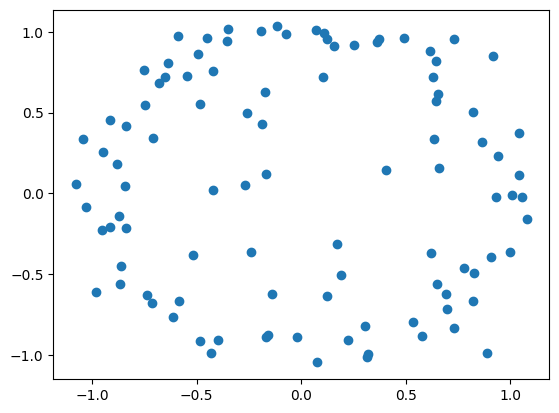

In [9]:
N = 60
M = 40
Z = sample_circle(N, rng, variance=0.005)
Y = sample_rectangle(M, rng)
X = np.r_[Z, Y]
plt.scatter(*X.T)
plt.show()

In [10]:
st_core = core_cech(X=X, max_dim=2, k=1)
st_alpha = core_alpha(X=X, k=1)

Note that since our methods return squared filtration values, we need to take square roots of persistence values.

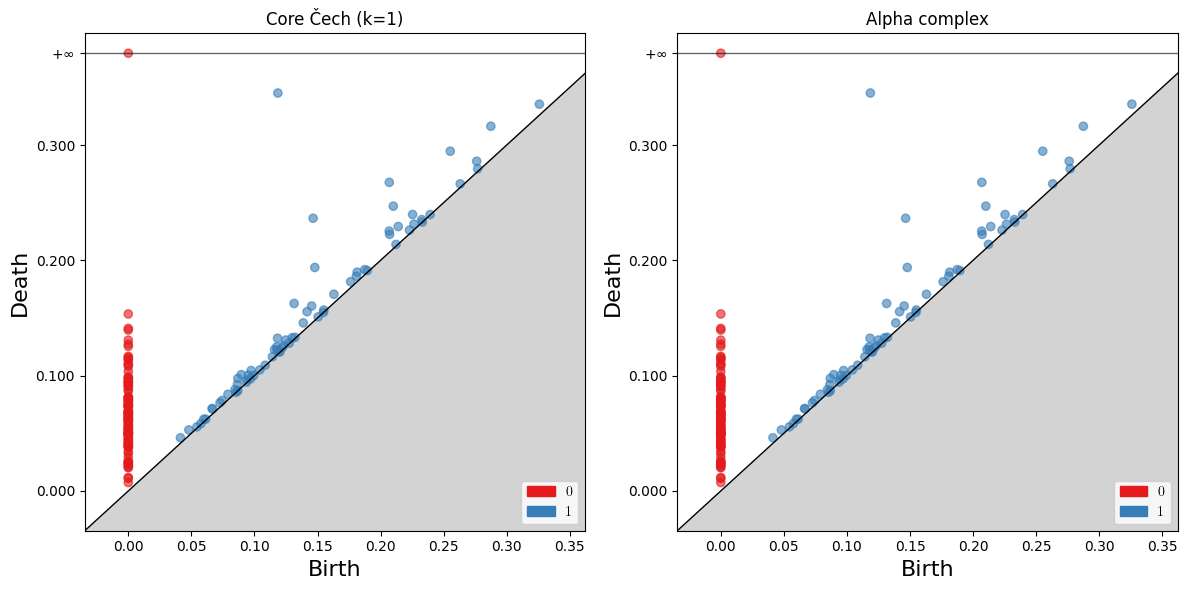

In [11]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
gudhi.plot_persistence_diagram(st_core.persistence(), axes=axs[0])
gudhi.plot_persistence_diagram(st_alpha.persistence(), axes=axs[1])
axs[0].set_title("Core Čech (k=1)")
axs[1].set_title("Alpha complex")
fig.tight_layout()
plt.show()

### Different values of $k$

We now compute the core Čech filtration for some different values of $k$ and plot the corresponding persistence diagrams.

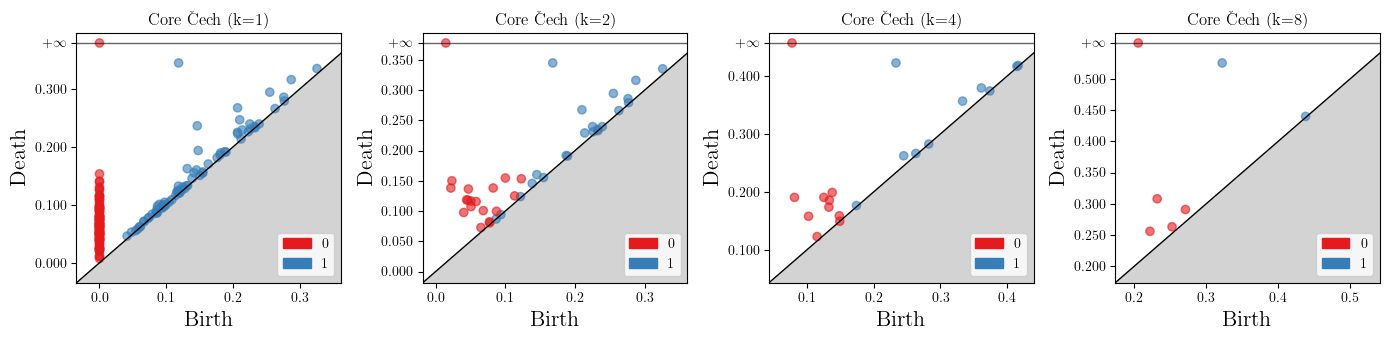

In [12]:
ks = [1, 2, 4, 8]

fig, axs = plt.subplots(ncols=len(ks), figsize=(14, 14 / len(ks)))
for i, k in enumerate(ks):
    st_core = core_cech(X=X, k=k, max_dim=2)
    gudhi.plot_persistence_diagram(st_core.persistence(), axes=axs[i])
    axs[i].set_title(f"Core Čech (k={k})")
fig.tight_layout()
plt.show()

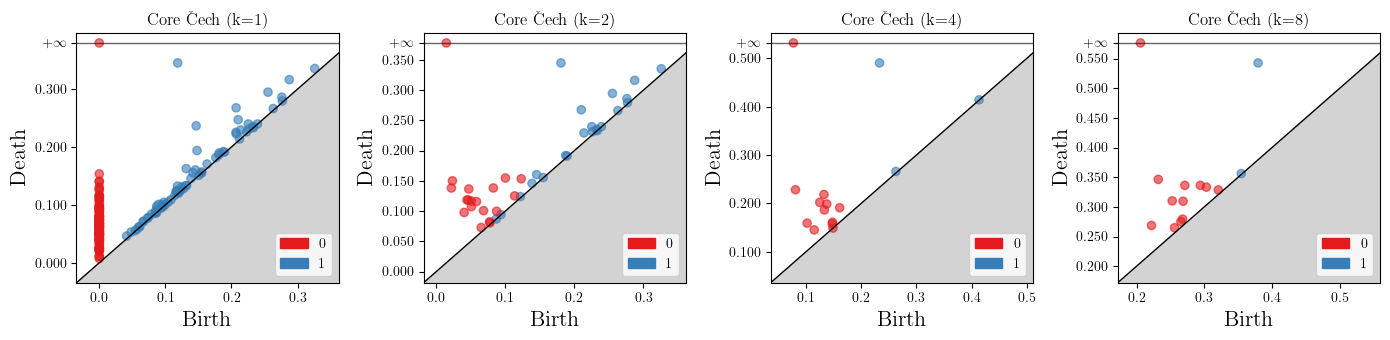

In [13]:
ks = [1, 2, 4, 8]

fig, axs = plt.subplots(ncols=len(ks), figsize=(14, 14 / len(ks)))
for i, k in enumerate(ks):
    st_core = core_alpha(X=X, k=k)
    gudhi.plot_persistence_diagram(st_core.persistence(), axes=axs[i])
    axs[i].set_title(f"Core Čech (k={k})")
fig.tight_layout()
plt.show()

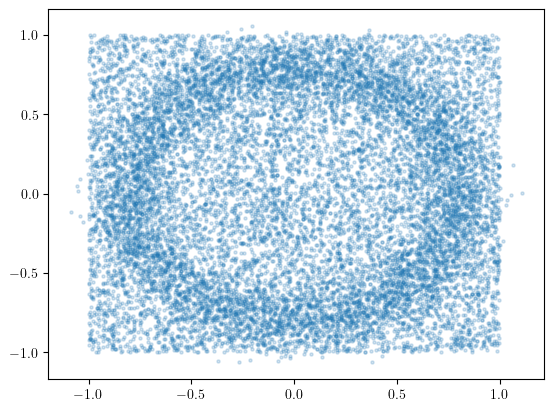

In [14]:
N = 5_000
M = 10_000
Z = sample_circle(N, rng, r=0.8, variance=0.01)
Y = sample_rectangle(M, rng)
X = np.r_[Z, Y]
plt.scatter(*X.T, s=5, alpha=0.2)
plt.show()

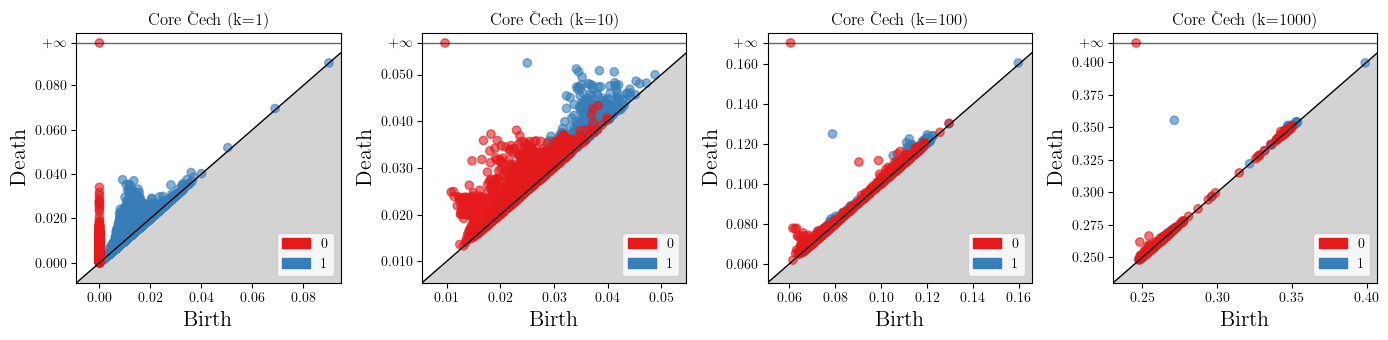

CPU times: user 4.26 s, sys: 185 ms, total: 4.45 s
Wall time: 4.2 s


In [15]:
%%time
ks = [1, 10, 100, 1000]
fig, axs = plt.subplots(ncols=len(ks), figsize=(14, 14 / len(ks)))
for i, k in enumerate(ks):
    st_core = core_alpha(X=X, k=k)
    gudhi.plot_persistence_diagram(st_core.persistence(), axes=axs[i])
    axs[i].set_title(f"Core Čech (k={k})")
fig.tight_layout()
plt.show()

In [16]:
%%time
st_core = core_alpha(X=X, k=1000)

CPU times: user 1.65 s, sys: 2.64 ms, total: 1.65 s
Wall time: 1.65 s
